In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
from TurbineTimeSeries.storage import MachineDataStore
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin

In [2]:
model_number = 2

store = MachineDataStore('.config')

model_data_hr = (store.query(model_number,'1hr')
                 .not_null(['timestamp','psn'])
                 .exclude_psn([44,52,54,70])
                 .execute())

model_data_min = (store.query(model_number,'10min')
                  .not_null(['timestamp','psn'])
                  .exclude_psn([44,52,54,70])
                  .execute())

model_data_min.head()

,id,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,g_c_dt2,lo_c_dt5,c_dt5_1,...,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1,timestamp,psn
0,1,0.378187,0.337323,-0.181580,0.283768,0.546667,0.352,0.398,0.444706,-0.021556,...,0.167029,0.714348,0.836571,0.3800,22452.305823,0.8516,0.10789,0.213541,2017-06-26 12:00:11.999995,39
1,2,0.384455,0.304681,-0.062424,0.281090,0.578889,0.360,0.374,0.443529,-0.019334,...,0.170886,0.713913,0.829714,0.3775,22452.415190,0.8472,0.11142,0.216346,2017-06-26 12:10:00.000004,39
2,3,0.395580,0.256122,0.017021,0.284209,0.567778,0.366,0.398,0.444706,-0.022222,...,0.162286,0.713043,0.834857,0.3770,22452.642025,0.8476,0.11171,0.214744,2017-06-26 12:30:00.000003,39
3,4,0.388409,0.268359,-0.073769,0.282309,0.564444,0.352,0.372,0.447059,-0.019722,...,0.161743,0.713043,0.826286,0.3750,22452.753418,0.8620,0.10986,0.214342,2017-06-26 12:39:59.999997,39
4,5,0.385170,0.269397,-0.175926,0.281459,0.567778,0.324,0.380,0.447059,-0.020722,...,0.165914,0.713913,0.829714,0.3760,22452.866835,0.8788,0.10974,0.215144,2017-06-26 12:50:00.000002,39


In [3]:
freq = '10min'
model_data = model_data_min
len(model_data)

1602740

In [4]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [5]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [6]:
data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [7]:
def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time laps in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
n = datetime.datetime(2015,12,5,0,10,0,4)
print(n)
print(roundTime(n,600))

2015-12-05 00:10:00.000004
2015-12-05 00:10:00


In [9]:
export_dir = '3hour/'
span = '3_hour'
def plot_cluster_distribution(psn=None):
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure(0)
    ax1 = plt.subplot2grid((1,1), (0, 0))
    ax1.bar(range(n_clusters),label_counts[:])
    ax1.set_ylabel('Segment Count')
    ax1.set_xlabel('Cluster')
    plt.suptitle("Model {} Cluster Distributions for Eigenvector {}, {} Profiles".format(model_number, 1, span))
    plt.grid("on")
    fig.savefig(export_dir+"model{}_{}_kmeans_{}_eig{}_{}_cluster_distribution.png".format(model_number,psn, n_clusters,1, span))
       
    plt.show()
    
def plot_cluster_grid(psn=None):
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

    grid_size = (n_clusters,1)
    cluster_means = []

    fig = plt.figure(0)
    row = -1
    shared_ax = None

    for i,c in enumerate(labels_sorted_by_freq):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
        cluster_means.append(pd.DataFrame(cluster_data).mean())
        
        col = i%15
        row = row if col > 0 else row+1
        
        ax = plt.subplot2grid((15,15), (row,col),sharey=shared_ax)
        
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        plt.axis('off')
        
        if shared_ax is None:
            shared_ax = ax     

        
    plt.suptitle("Model {} Eigenvector {}, {} Profiles".format(model_number, 1, span))  
    fig.savefig(export_dir+"model{}_{}_kmeans_{}_eig{}_{}_cluster_grid.png".format(model_number,psn, n_clusters,1, span, psn))
    plt.close()
    
def plot_clusters(c_idx,psn=None):
    plt.rcParams["figure.figsize"] = (14, 7)
    for i, c in enumerate(c_idx):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
                
        fig = plt.figure(0)
        ax = plt.subplot2grid((1,1), (0,0))
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        ax.set_xlabel('Time of Day')
        plt.suptitle("Model {} Eigenvector {}, {} Cluster {} ".format(model_number, 1, i+1, span))  
        fig.savefig(export_dir+"model{}_{}_kmeans_{}_eig{}_{}_cluster{}.png".format(model_number,psn, n_clusters,1, i+1, span))
        plt.close()
      

34 2018-05-02 08:47:14.443334
	 time parsing done 2018-05-02 08:47:15.934129
	 block grouping done 2018-05-02 08:47:26.227905
	 block aggregating done 2018-05-02 08:48:08.555625


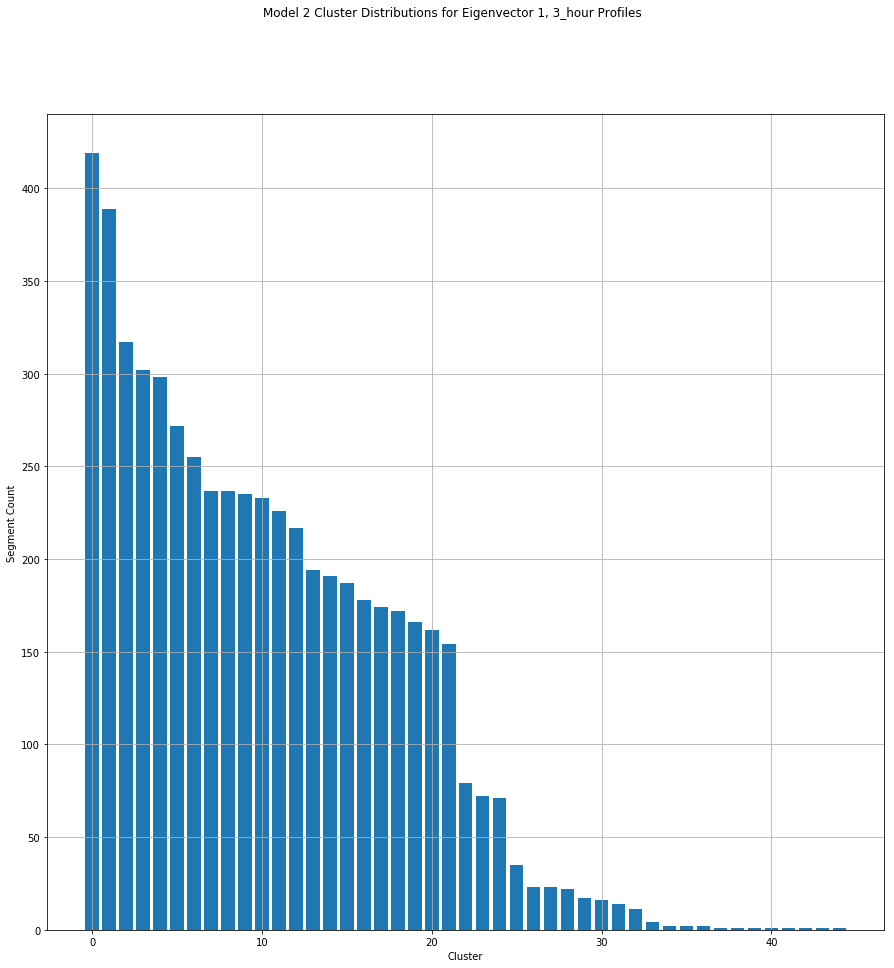

	 clustering done 2018-05-02 08:48:24.897506
35 2018-05-02 08:48:24.897506
	 time parsing done 2018-05-02 08:48:26.025669
	 block grouping done 2018-05-02 08:48:33.470743
	 block aggregating done 2018-05-02 08:48:56.751191


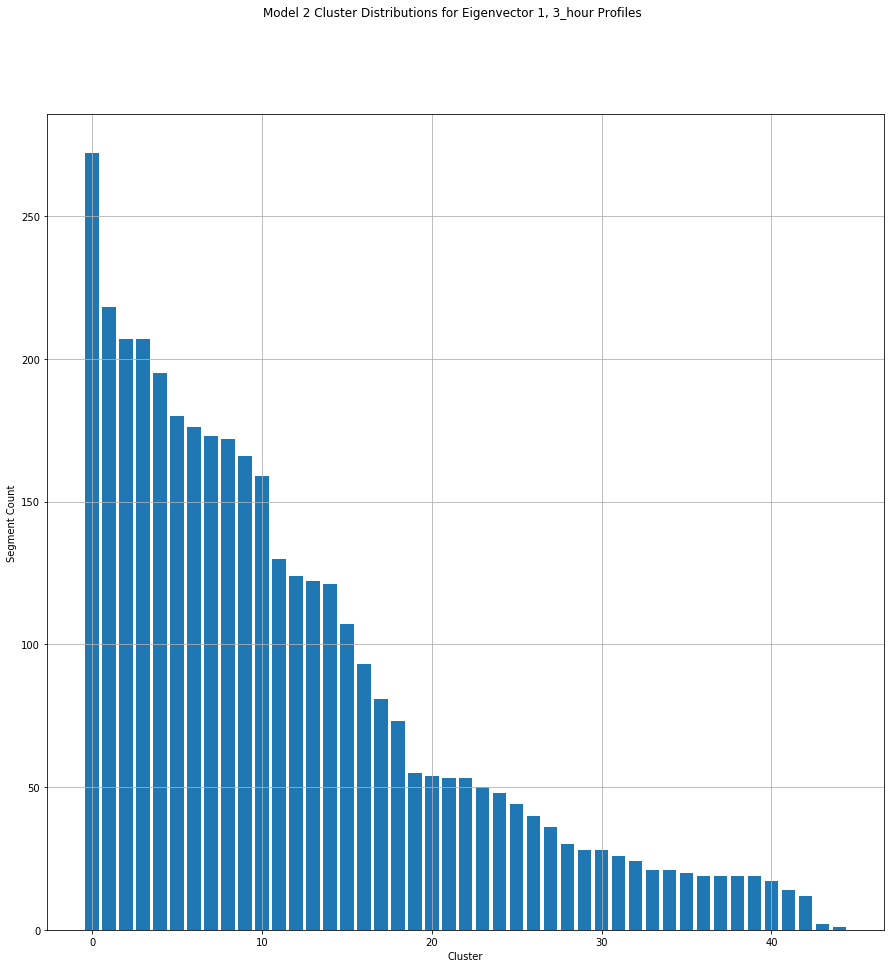

	 clustering done 2018-05-02 08:49:08.069947
36 2018-05-02 08:49:08.070973
	 time parsing done 2018-05-02 08:49:09.231306


In [ ]:
eigenvectors_to_segment = 1
twelve_hour_segments = []

def twelve_hour_group(x):
    return str(x['iso'][0])+'-'+str(x['iso'][1])+'-'+str(x['iso'][2])+'-'+(str(int(x['hour']/3)))
for i in range(eigenvectors_to_segment):
    twelve_hour_segments.append([])
    
for psn in data['psn'].sort_values().unique():
    print(str(psn), datetime.datetime.now())
    psn_data = pd.DataFrame(data[(data['psn'] == psn)])
    psn_data['timestamp'] = psn_data['timestamp'].apply(lambda x: roundTime(datetime.datetime(x.year,x.month,x.day,x.hour,x.minute,x.second),600))
    psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
    psn_data['hour'] = psn_data['timestamp'].apply(lambda x: x.time().hour)
    psn_data['minute'] = psn_data['timestamp'].apply(lambda x: x.time().minute)
    
    print('\t time parsing done', datetime.datetime.now())
    psn_data['twelve_hour_group'] = psn_data.apply(twelve_hour_group,1)
    complete_groups = (psn_data.groupby(by=['twelve_hour_group']).count()['id'] == 18)
    psn_data['complete_group'] = psn_data['twelve_hour_group'].apply(lambda x: complete_groups[x])
    psn_data = psn_data[psn_data['complete_group'] == True]
    print('\t block grouping done', datetime.datetime.now())
    psn_segments = [[],[],[],[]]
    for d in psn_data['twelve_hour_group'].unique():
        group_data = (psn_data[psn_data['twelve_hour_group'] == d]).sort_values(by='timestamp')
        idx = group_data.index
       
        for i in range(eigenvectors_to_segment):
            psn_segments[i].append([x for x in reduced[idx,i]])
                
            twelve_hour_segments[i].append(psn_segments[i])
    print('\t block aggregating done', datetime.datetime.now())
    to_be_clustered = psn_segments[0]
    n_clusters=45

    if len(to_be_clustered) >= n_clusters:
        cluster = KMeans(n_clusters)
        cluster.fit(to_be_clustered)
        label_df = pd.DataFrame(cluster.labels_)
        label_counts = label_df[0].value_counts().sort_values(ascending=False)
        labels_sorted_by_freq = list(label_counts.keys())

        plot_cluster_distribution(psn)
        plot_cluster_grid(psn)
        if i == 0:
            plot_clusters(labels_sorted_by_freq, psn)
    print('\t clustering done', datetime.datetime.now())
    
   
   
 